# Summary

This is an attempt to explore the service data set and understand the data.<br> I have disussed the following in the below sections<br> 1. EDA : In this section I binned some of hte categorical varaibles and look at their distributions, relationship between features and possible explanations/actions. Through this,identified the problem statement of identifying repeat visits <br> 2. Split the set into predictor set and label <br> 3. Split the set into train and test <br> 4. Filling missing values <br> 5. Parts sent feature <br> 6. Class imbalance - downsampling <br> 7. Feature Selection <br> 8. Modeling <br> 9. Observations

# Import libraries

In [1]:
from pandas import Series, DataFrame
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score,f1_score,recall_score,confusion_matrix,auc,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt 
%pylab inline
import re

Populating the interactive namespace from numpy and matplotlib


Let's read in the data.

In [2]:
df=pd.read_csv("Data.csv")

In [334]:
df.head(2)

,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type,topic_category,parts_sent,repair_type,repeat_ct,parts_ct,agent_tenure_indays,contact_manager_flg,diagnostics,repeat_parts_sent,region,country
0,0,Laptops,201726,201726,202125,201840,Voice,NaN,NaN,"Hard Drive, Documentation(2)",Hard,0,3,1018.0,0,Not_USED,NaN,Hogwarts,NaN
1,1,Laptops,201650,201650,201949,201840,Voice,NaN,NaN,"Speaker, Chassis",Hard,0,2,1018.0,0,Not_USED,NaN,Hogwarts,Zonko's Joke Shop


In [335]:
df.shape

(100000, 19)

This dataset contains 100000 customer service logs in the 40th week of 2018 and their stats including type of product,manufacturing,warranty information,issue and agent details. Let's clean the data a bit and look at missing values.

In [336]:
df.columns

Index(['asst_id', 'product_type', 'mnfture_wk', 'contract_st', 'contract_end', 'contact_wk', 'contact_type', 'issue_type', 'topic_category', 'parts_sent', 'repair_type', 'repeat_ct', 'parts_ct', 'agent_tenure_indays', 'contact_manager_flg', 'diagnostics', 'repeat_parts_sent', 'region', 'country'], dtype='object')

In [337]:
#dropping duplicate rows
df=df.drop_duplicates(subset='asst_id')

In [338]:
df.shape

(82442, 19)

After dropping the duplicates, we now have 82442 customer service logs in the data with 19 features.

# Missing values

In [339]:
(df.isna().sum()/df.shape[0])*100 #% of missing values in the features

asst_id                 0.000000
product_type            0.023047
mnfture_wk              0.000000
contract_st             0.000000
contract_end            0.000000
contact_wk              0.000000
contact_type            0.010917
issue_type             13.830329
topic_category         32.808520
parts_sent             45.577497
repair_type             0.000000
repeat_ct               0.000000
parts_ct                0.000000
agent_tenure_indays     0.010917
contact_manager_flg     0.000000
diagnostics             0.000000
repeat_parts_sent      86.852575
region                  0.003639
country                10.010674
dtype: float64

Some features have high  number of missing values. While this is worrying at first sight, we need to check if the missing values have some meaning in them. Let's explore the data to find if there could possibly be relations in the features to impute the missing values.

In [340]:
#cleaning misspellings
def merge_words(s):
    misspellings = {'Voice':'VOICE'}
    if s in misspellings:
        return misspellings[s]
    else:
        return s

In [341]:
# Apply the function to the Series
df['contact_type'] = df['contact_type'].map(merge_words)

# Check that it worked
mask = (df['contact_type'] == 'Voice')

We have corrected for misspellings now

# 1. EDA

Let's look at the distribution of numerical features and bin some of them. This would help in exploring relationships between variables and interpret them better.

In [343]:
numerical_features=['mnfture_wk', 'contract_st', 'contract_end',
                    'contact_wk','repeat_ct','parts_ct', 
                    'agent_tenure_indays']
cat_features=['product_type','contact_type', 'issue_type', 'topic_category', 
                    'parts_sent', 'repair_type','contact_manager_flg','diagnostics', 
                    'repeat_parts_sent', 'region', 'country','tenure_buckets',
                  'war_cont_status','manu_status']

mnfture_wk


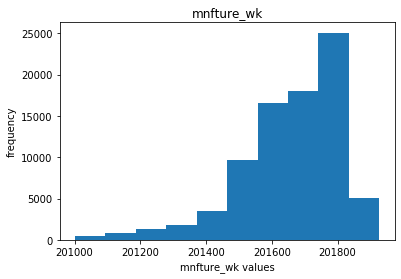

-----------------------------------------
contract_st


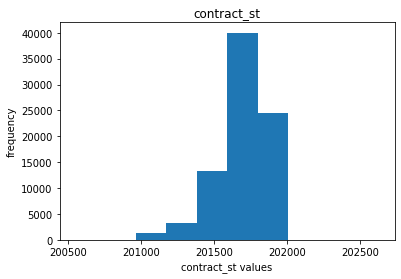

-----------------------------------------
contract_end


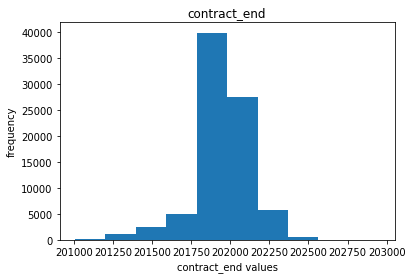

-----------------------------------------
contact_wk


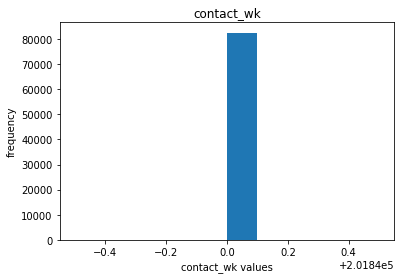

-----------------------------------------
repeat_ct


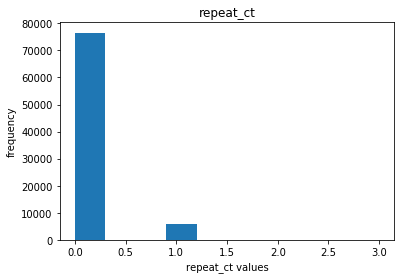

-----------------------------------------
parts_ct


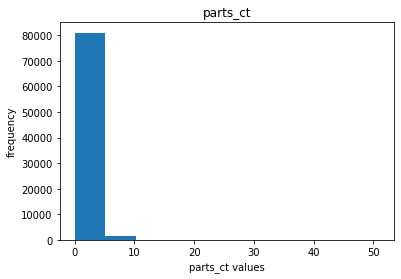

-----------------------------------------
agent_tenure_indays


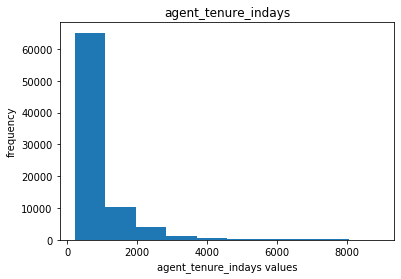

-----------------------------------------


In [344]:
for col in numerical_features: 
    print(col)
    
    num_bins = 10
    plt.hist(df[col], num_bins)
    plt.xlabel(col + ' values')
    plt.ylabel('frequency')
    plt.title(col)
    plt.show()
    print('-----------------------------------------')

Observations:<br> 1. There is a skew in the manufacture week distribution implying that most of the repair logs of this week is from products that were manufactured 2 years ago. <br> 2.Contract start and end weeks seem to have an approximate normal distribution<br> 3.Contact wk is a constant value and has no variance. So, this would add no information. Hence, I would drop it off after further exploration <br> 4. The repeat count is concentrated at 0 and 1 with only few events having >1<br> 5. The age in tenure is also skewed with most of the agents being less than 2 years.

# 1.1 Feature Engineering

Columns created:<br>
tenure_buckets: From the distribution, since most of the complaints are handled by agents less than 5 years, let's bin the tenure of agent feature into 4 groups - 0-12 months,1-2 years, 2-5 years, greater than 5 years.

In [345]:
#binning tenue of agent
df['tenure_buckets']='Greater than 5'
df['tenure_buckets']=np.where(df['agent_tenure_indays']<=365,'0-12 months',
                    np.where((df['agent_tenure_indays']>365)&(df['agent_tenure_indays']<=730),'1-2 years',
                    np.where((df['agent_tenure_indays']>730)&(df['agent_tenure_indays']<=1825),'2-5 years',
                    df['tenure_buckets'])))

Assumptions on the time variables: Manufacturing week is also the week the product has been shipped. Warranty starts when the product is invoiced.

war_cont_status: This measures the time difference in weeks between when warranty ended and contact week(war_cont). There are 3 groups in this:<br>(a) warranty over - which is when the diff=0, meaning those logs have been made on the week of when warranty is ending<br> (b) before warranty : This group of customers have contacted before the end of warranty<br> (c) after warranty - They have contacted after their warranty has ended.<br> Now, group C is an interesting group as with careful considerations of customer experience, they are a group of revenue opportunity in terms that they pay us for repair and also we could cross sell warranty extensions to them.

In [346]:
def calc_day_from_yrweek(date1,date2):
    year1=int(str(date1)[:4])
    week1=int(str(date1)[4:])
    year2=int(str(date2)[:4])
    week2=int(str(date2)[4:])
    
    yr_days=((year1)-(year2))*365
    wk_days_a=(week1)*7
    wk_days_b=(week2)*7
    diff=(yr_days-wk_days_b+wk_days_a)//7
    return diff

In [347]:
#creating diff of time variables
df['war_cont']=df.apply(lambda x: calc_day_from_yrweek(x.contract_end, x.contact_wk), axis=1)

# binning the time diff varaibles
df['war_cont_status']='warranty over'
df['war_cont_status']=np.where(df['war_cont']>0,'before warranty',np.where(df['war_cont']<0,
                                            'after warranty',df['war_cont_status']))

manu_status: This measures the time difference in weeks between when the product was manufactured and when the warranty starts. It has been assumed that the week of manufacturing = week of shipping and warranty starts on the day of invoice.<br>
There are 3 groups:<br>(a) invoiced - which is when the diff=0, meaning the product has been sold in the same week as when it was manufactured<br> (b) invoiced later : This means that the product was manufactured and sold in the later weeks<br> (c) customized - This is when the invoice has happened and then the product is shipped.<br> Now, group C seem to be customers who like customized products, which could be treated as a pseudo to understand that they are a product lover and so their service experience should be premium. With the right service, they would become loyals of the firm as when they get attached to a product, they seldom switch.

In [348]:
df['diff_manu_contr']= df.apply(lambda x: calc_day_from_yrweek(x.mnfture_wk, x.contract_st), axis=1)

df['manu_status']='invoiced'
df['manu_status']=np.where(df['diff_manu_contr']>0,'customized',
                np.where(df['diff_manu_contr']<0,'invoiced later',df['manu_status']))


time_contrst_cont: Gives how many weeks after the contract has started have they contacted us this week.
time_manu_cont: Gives how many weeks after manufacture have they contacted us this week.

In [349]:
df['time_contrst_cont']=df.apply(lambda x: calc_day_from_yrweek(x.contact_wk, x.contract_st), axis=1)
df['time_manu_cont']=df.apply(lambda x: calc_day_from_yrweek(x.mnfture_wk, x.contact_wk), axis=1)
# df['time_contrend_cont']=df.apply(lambda x: calc_day_from_yrweek(x.contact_wk, x.contract_end), axis=1)

From the distribution of repeat count, we see that most occurences are zero and one followed by a  few other values. So, changing the repeat count into a binary variable.<br> <br>Repeat: when repeat count >0 <br> Non repeat: when repeat count = 0

In [350]:
#creating new column repeat
df['repeat']=0
df['repeat']=np.where(df['repeat_ct']>0,1,df['repeat'])

# 1.2 Distribution of categorical features

Let's now look at the distribution of the categorical features. This usually tells us which are the dominant categories present in the data.

In [351]:
#function to plot the count of logs in each category of the feature 
def plot_dist(column):
    x=round((df.groupby(column)['asst_id'].count()/df.shape[0])*100,2).sort_values(ascending=False)[:10].plot(kind='bar')
    x.plot(kind='bar')
    xlabel(column)
    ylabel('% of repair log')
    plt.title('Distribution of repair log on '+ column)

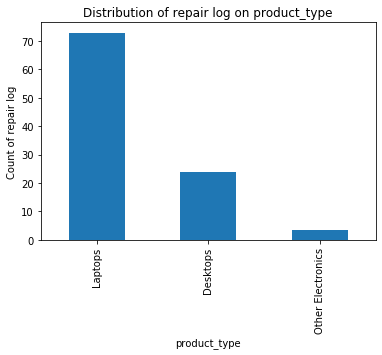

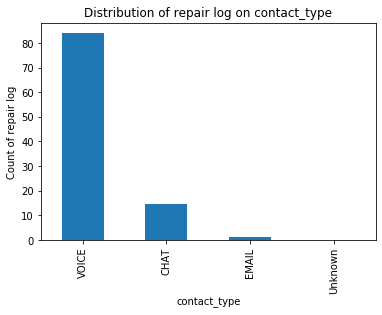

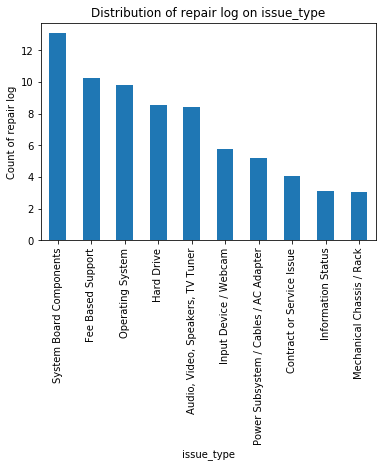

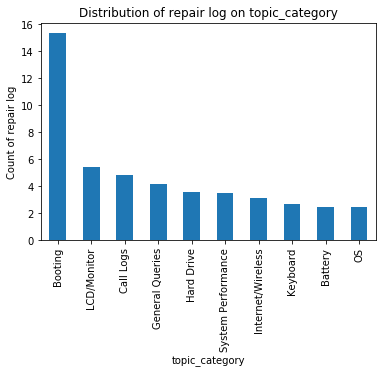

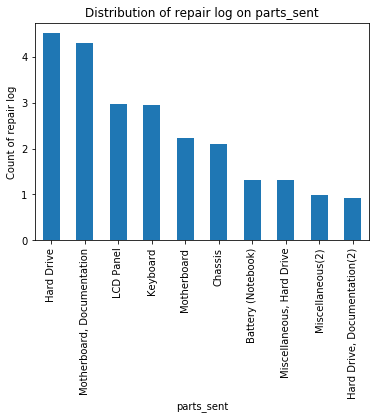

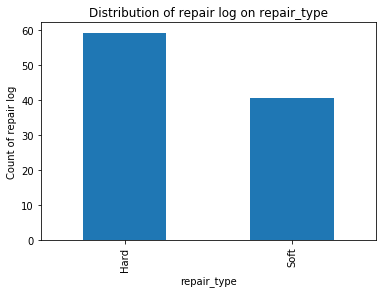

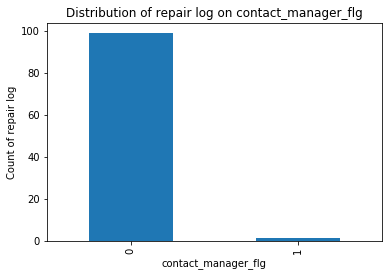

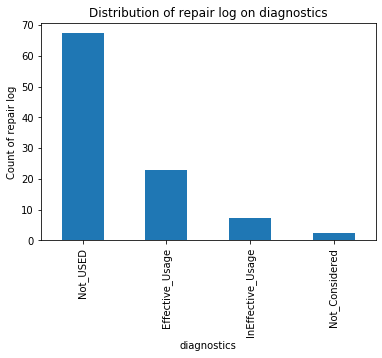

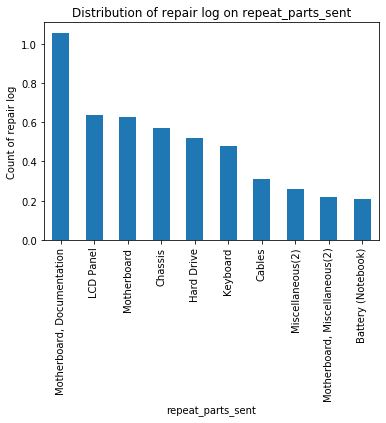

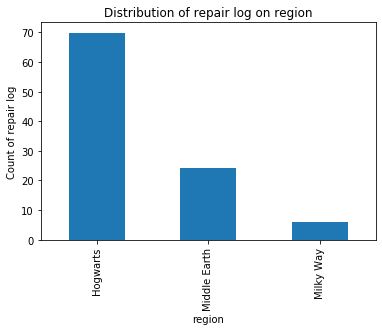

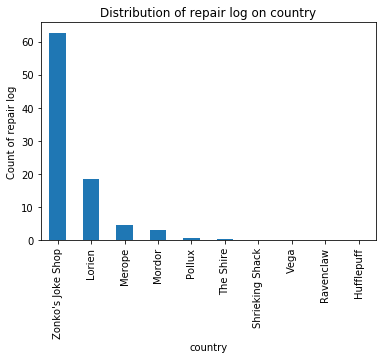

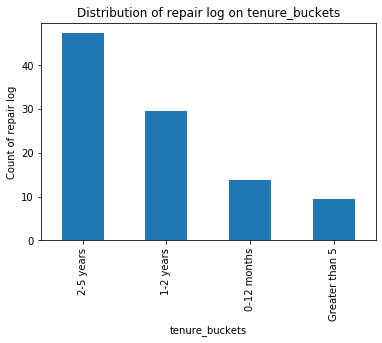

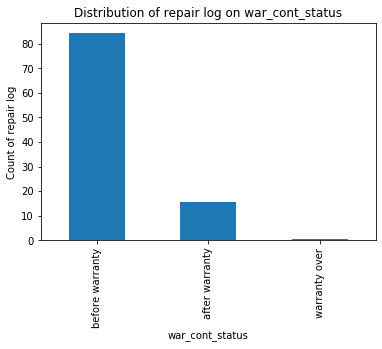

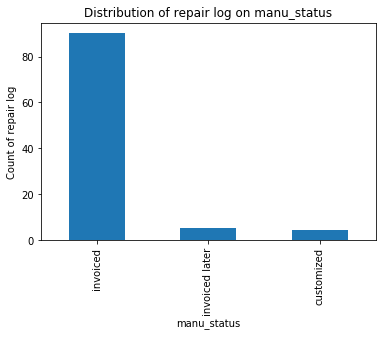

In [352]:
for i in range(0,len(cat_features)):
    plot_dist(cat_features[i])
    plt.show()

Observations:<br> From the logs that were recorded in the week, we see around 70% of the repairs happening on laptops and > 80% of customers have contacted via the Voice channel. <br> <br>Common issues seem to be tagged as Booting, LCD/Monitor and mostly the parts sent are hardware parts like Hard drive, Motherboard, LCD Panel. Cases where parts were sent, it would be tagged as hard repair type. This data set is heavy on hard repair type.
<br> <br>Now, how are the issues solved? Using the features given, my understanding is the agents are trained to use a diagnostics tool to identify the issue and then advice accordingly. However, around 70% of the cases have not used the tool. This possibly translates to dampen customer experience --> potential revisit by customer --> increased cost to the company. However, the good thing is only 1% of cases have been escalated.<br> <br>Where is all this happening? Mostly in the Hogwarts country and the Zonko's Jooke Shop. That's right! You read it right. <br> <br> When is all this happening? Close to 70% before warranty ends and 15% after warranty has ended. 

# 1.3 Diagnostics 

Let's now look at the relationship between the diagnostic categories and the other features. This parameter could influence the experience of the customer in getting the issue resolved.<br> It could potentially answer business problems in the area of customer experience, time it takes to solve an issue, performance of an agent, training/focus needed on which group of agent. Also, good customer experience most often translates to repeat purchase and so this could latently influence revenue in the future as well. 

# Effect of escalation on diagnostics

In [353]:
mgr_diag=pd.crosstab(df['contact_manager_flg'],df['diagnostics'])
round(mgr_diag.T/mgr_diag.T.apply(sum)*100,2)   #the output is in %

contact_manager_flg,0,1
diagnostics,,
Effective_Usage,22.01,94.63
InEffective_Usage,7.28,5.37
Not_Considered,2.55,0.00
Not_USED,68.15,0.00


100% of the cases that get escalated to the manager have used the diagnostics tool and 94% of the cases have been solved using effective usage of the tool. This shows that when the manager gets involved, then the tool is being used by the agent. In 68% of the non-escalated cases, it is not used at all. This clearly shows that there needs to be more rigour in enforcement of usage of diagnostic tool among the agents. Let's try and find out which set of agents.

# Effect of Tenure on Diagnostics

In [354]:
ten_diag=pd.crosstab(df['tenure_buckets'],df['diagnostics'])
round(ten_diag.T/ten_diag.T.apply(sum)*100,2)   #the output is in %

tenure_buckets,0-12 months,1-2 years,2-5 years,Greater than 5
diagnostics,,,,
Effective_Usage,29.94,25.82,20.03,18.06
InEffective_Usage,9.07,8.48,6.24,5.90
Not_Considered,2.02,2.89,2.55,1.99
Not_USED,58.98,62.81,71.18,74.05


The usage of the diagnostic tool seems to be going down with growing age of tenure. So, effective usage is going down. The ineffective usage is also going down as age of tenure increases. This shows that while agents are definitely familiarized with the tool as their time in the organization increases, they are not motivated to use the tool effectively. So, refreshers on the tool to the agents >12 months and training on how to use them effectively to agents <12 months would help. Let's now help the trainers identify which type of repair is being solved more effectively using the tool.

# Effect of Repair Type on Diagnostics

In [355]:
rep_diag=pd.crosstab(df['repair_type'],df['diagnostics'])
round(rep_diag.T/rep_diag.T.apply(sum)*100,2)    #the output is in %

repair_type,Hard,Soft
diagnostics,,
Effective_Usage,25.44,19.22
InEffective_Usage,10.71,2.22
Not_Considered,0.92,4.86
Not_USED,62.93,73.70


The results are as expected. The tool has been used more for hard type cases (which means mostly hardware related issues). So, the trainers could focus on training the agents more on the hard type issues and how to solve them using the tool. Now, let's see which team of agents needs to be trained.

# Effect of Contact Type on Diagnostics

In [356]:
cont_diag=pd.crosstab(df['contact_type'],df['diagnostics'])
round(cont_diag.T/cont_diag.T.apply(sum)*100,2)    #the output is in %

contact_type,CHAT,EMAIL,Unknown,VOICE
diagnostics,,,,
Effective_Usage,31.42,6.34,4.49,21.72
InEffective_Usage,8.34,1.68,0.00,7.17
Not_Considered,3.59,0.47,0.00,2.37
Not_USED,56.65,91.51,95.51,68.73


Agents on the email channel do not seem to use the diagnostic tool. Not used is very high at 91%. This could possibly be because<br>1. They receive more soft issue types as the agents in general seem to use the tool more for hard issue type when compared with soft (we saw this in previous table).Let's check this next.<br>2. Email channel is not a live contact channel where both the agent and customer are in contact with each other at the time. So, might not be very effective.

# 1.4 Effect of Repair_type on Contact_type

In [357]:
cont_rep=pd.crosstab(df['contact_type'],df['repair_type'])
round(cont_rep.T/cont_rep.T.apply(sum)*100,2)   #the output is in %

contact_type,CHAT,EMAIL,Unknown,VOICE
repair_type,,,,
Hard,74.86,84.61,59.55,56.3
Soft,25.14,15.39,40.45,43.7


Our hypothesis that email receives more soft issues is wrong as 84% of the issues are of hard type. So, this clearly shows that the agents on the email channel are not being compliant in the usage of the diagnostic tool. So, that's where I'd start to talk to the team and understand why this is the case. Having said that, there is definitely opportunity to use this tool more effectively across channels.

Let's now look into the cases that have contacted us after their warranty is over.

# 1.5 After warranty customer logs

The reason into looking into after warranty logs specifically is to understand if this could be revenue and better customer experience oppportunities. These customers clearly use the product and are probably going to continue to use the product. That's why they have made the effort to correct the issue. So, these set of customers with good experience would translate to high NPS scores for the firm (a happy customer matters!)

Let's see what % of the logs are in this bucket?

In [358]:
#repairs after warranty period ended
mask=df['contract_end']>df['contact_wk']
round((df.shape[0]-(mask).sum())/df.shape[0]*100,2)

15.73

15% is a sizable opportunity that could make a difference to the business.

Now, let's see how their stats on the type of repair, issues vary from the entire data set.

In [359]:
aft_war=df[df['war_cont_status']=='after warranty']

In [360]:
def plot_dist_war(column):
    x=aft_war.groupby(column)['asst_id'].count().sort_values(ascending=False)[:10]
    x.plot(kind='bar')
    xlabel(column)
    ylabel('Count of repair log after warranty ended')
    plt.title('Distribution of after warranty repair log on '+ column)

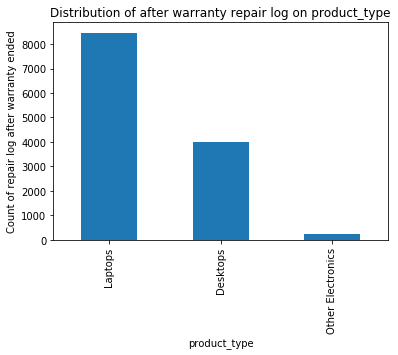

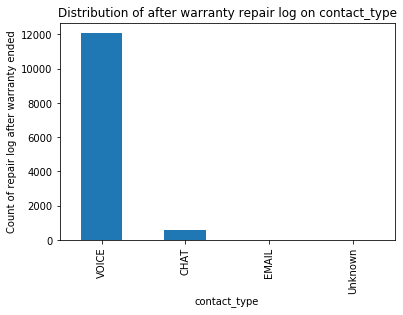

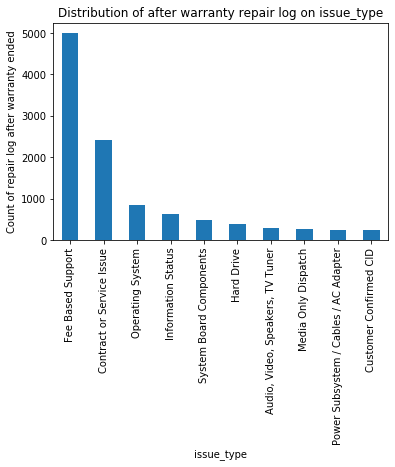

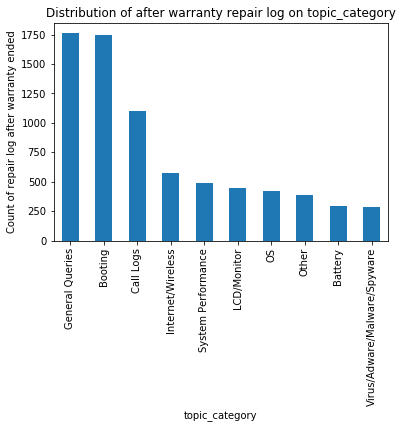

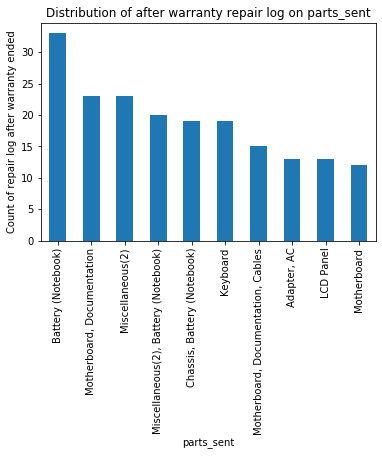

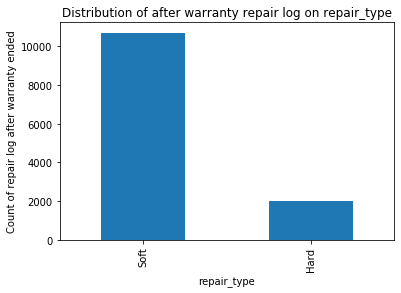

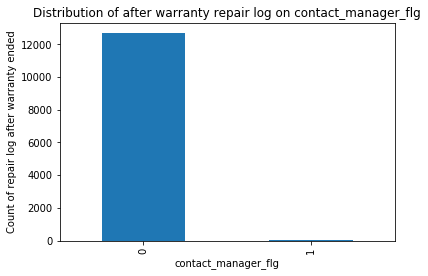

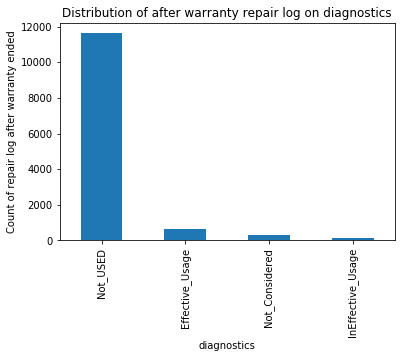

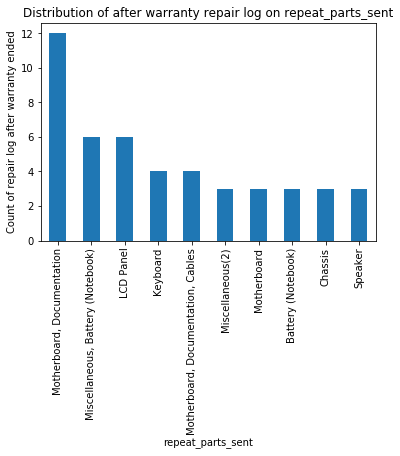

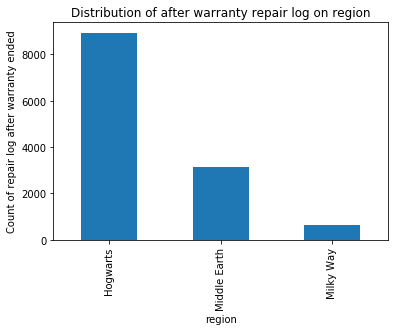

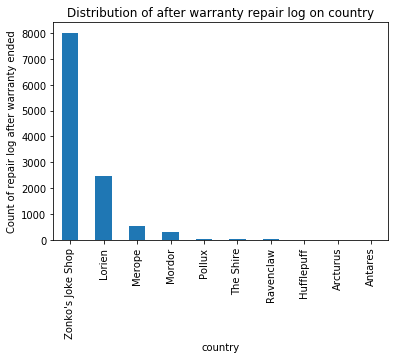

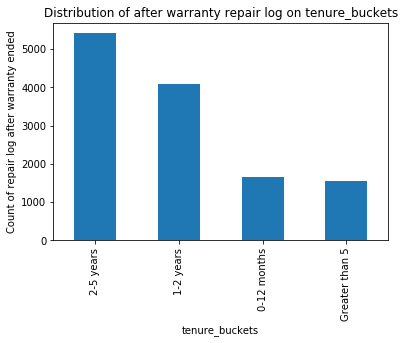

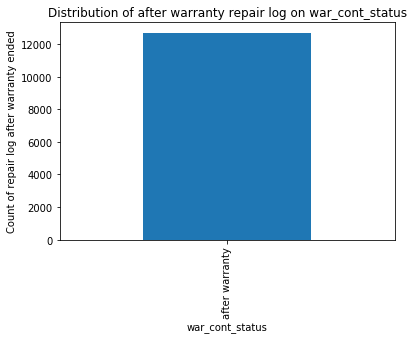

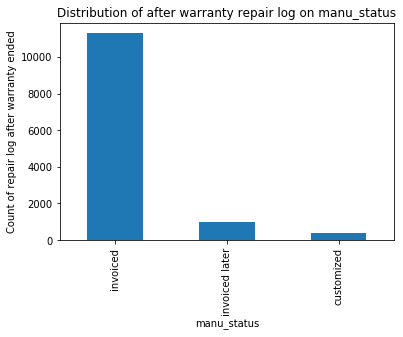

In [361]:
for i in range(0,len(cat_features)):
    plot_dist_war(cat_features[i])
    plt.show()

After Warranty customer logs Observations:<br> 1. The dominant product type is still Laptop. However, with no information on how many laptops were sold in total, we would not be able to tell if this really is the product with high issues. <br> 2. Voice/Chat seem to be the preferred modes of contact overall and for the after warranty customers as well. While this is expected, I am not sure what is the cost related with calls vs chat at this firm. But in my experience, I have seen that chats could turn to be cheaper than the voice channel. Also, if it is a machine trained bot, with capital investment, it could solve the attrition problem in the agents. <br> 3. The issues they contact for is more of service issues than hardware issues in the category. This means that these calls could potentially be avoided by giving information related to these issues on the website. Also, for now with the data I have, I would use it to rank order it on the website. <br> 4. Soft issues are more : >80%. This means that the revenue opportunity in terms of part purchase is thin, but still we could cross sell warranty extension to them. 

# 1.6 Soft Issues

Let's now see what are the main issue types that are being logged and classified as soft. This intersects with the space of after warranty customers(revenue opportunity) and the issues that could be self serviced by the customer.   

Text(0.5, 1.0, 'Top issue types in Soft complaints')

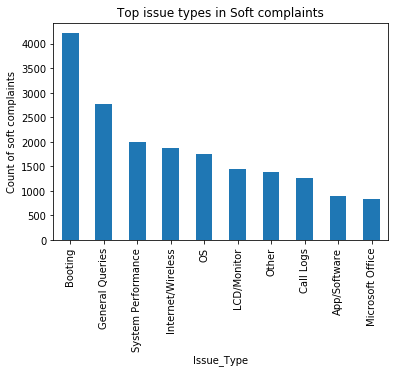

In [362]:
df[df['repair_type']=='Soft']['topic_category'].value_counts().\
sort_values(ascending=False)[:10].plot(kind='bar')
plt.xlabel('Issue_Type')
plt.ylabel('Count of soft complaints')
plt.title('Top issue types in Soft complaints')

Top issues seem to be categorized as Booting, General Queries, System Performance, Internet/Wireless : These look like problems that could be troubleshooted by the customer and so self-servicing gives them better experience and is a cost saving avenue for the firm. 

# Effect of age of product on repair type

No handles with labels found to put in legend.


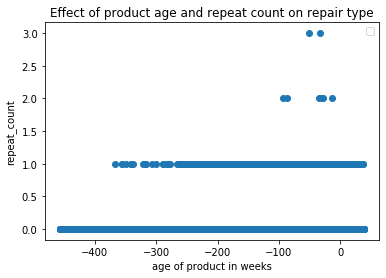

In [363]:
plt.scatter(df['time_manu_cont'],df['repeat_ct'],marker='o', linestyle='None')
xlabel('age of product in weeks')
ylabel('repeat_count')
plt.title('Effect of product age and repeat count on repair type')
legend(numpoints=1, loc='best')
show()

The age of the product(taken as the time from manufacture to week of contact) does not seem to have an effect on repeat count

# 1.7 Effect of time variables on repair log

# Time Manu week on repair log

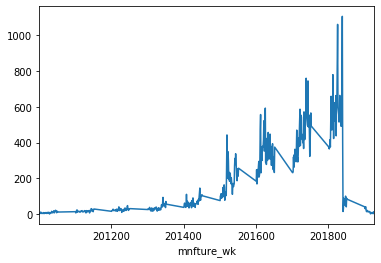

In [364]:
df.groupby('mnfture_wk')['asst_id'].count().plot(kind='line')
plt.title('Manufacturing week vs repair freq')
plt.ylabel('Count of repair log')

The repair complaints seem to be in fluctuating peaks from 2 years behind the week of contact. So, newer products are giving trouble. More importantly, there has been a peak in the 39th,26th,25th week of 2018. So, the products that got manufactured last week could have some kind of particular manufacturing/delivery issue that consumers are calling us. Let's look into issue type for this particular week. <br> Note: There is data with manufacture date in 2019, but contact week in 2018. This is likely bad data.

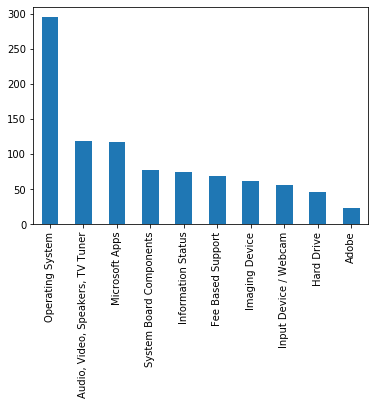

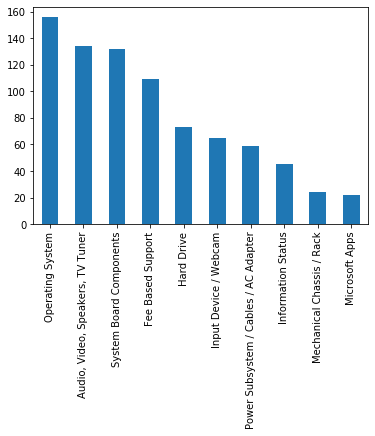

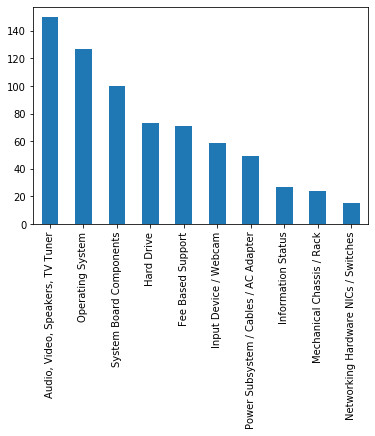

In [365]:
week=[201839,201826,201825]
for i in week:
    df[df['mnfture_wk']==i]['issue_type'].value_counts()[:10].plot(kind='bar')
    plt.show()

Operating system seems to be the biggest issue and this is a pattern in all the peak complaint weeks. We already saw that the top issues that customers call for are System Board components and Fee based support, followed by OS. So, clearly these peak weeks seem to be OS related and prior identification of this by the team could help in resource reallocation for the increased traffic. Also, we could proactively communicate how to solve this issue if its solvable using the support tool, as it is a soft issue.

# Time after start of warranty on repair log

Text(0, 0.5, 'Count of repair log')

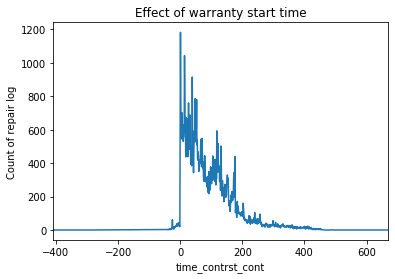

In [366]:
df.groupby('time_contrst_cont')['asst_id'].count().plot(kind='line')
plt.title('Effect of warranty start time')
plt.ylabel('Count of repair log')

Calls are high when the contract starts. This is customers getting used to the new product

After looking into the issues and time variables, analysing the usage of the diagnostics tools, I'm curious to see why is there a repeat visit needed to fix the problem,if we have all of that in place. So, for this let's understand more about the repair logs when actually a repeat has happened.

# 1.8 Effect of features on repeat

We are now looking at the proportion of repair logs for each category in the feature. For example, in product type,what is the proportion of logs in 'Desktops' out of the total repair logs in 'Desktop' that have repeated. In the graph below we would see that around 58% of the desktop repair logs have had repeat visits.

In [367]:
def plot_repeat_try(data):
    x = pd.crosstab(data,df['repeat'])
    total_x = x.T.apply(sum)
    x_repeat = (x.T/total_x).reset_index()
    x_repeat_= x_repeat[x_repeat['repeat']==1].drop(['repeat'],axis=1)
    x_repeat_.plot(kind='bar')
    xlabel('repeat')
    ylabel('Proportion of repair logs')
    plt.title('Effect of ' + features[i] + ' on repeat')

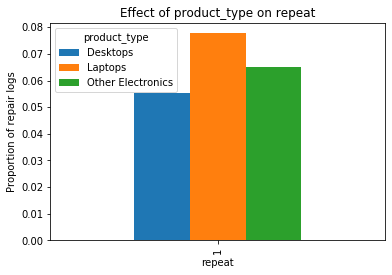

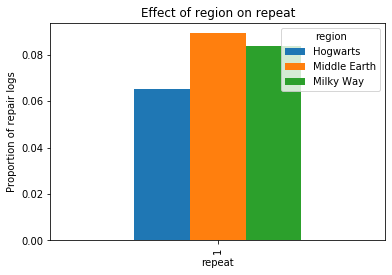

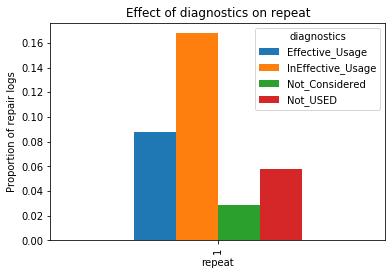

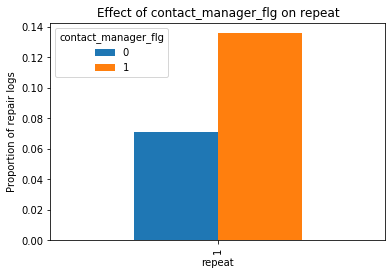

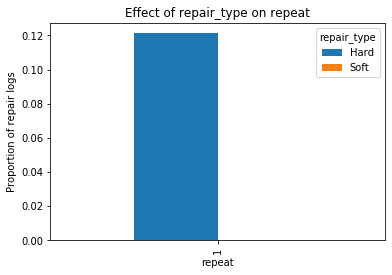

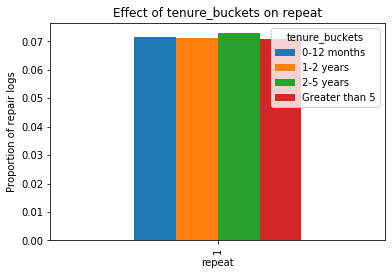

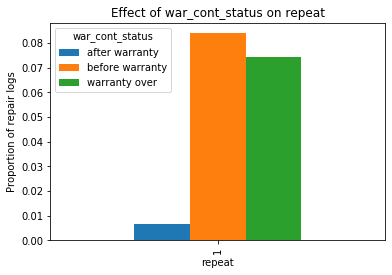

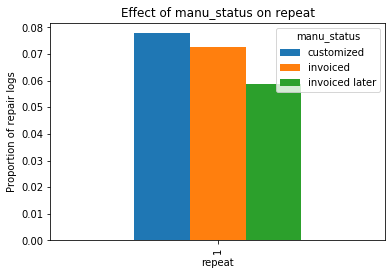

In [368]:
features=['product_type','region','diagnostics','contact_manager_flg','repair_type',
          'tenure_buckets', 'war_cont_status','manu_status']
for i in range(0,len(features)):
    plot_repeat_try(df[features[i]])

Observations:<br> 1. The Middle Earth region has a higher proportion of repeat, but is still lesser number of repeat cases than Hogwarts owing to the lesser number of the repairs in the region <br> 2. The proportion of repeats when the diagnostic tool is not used effectively is higher and this intuitively makes sense.  <br> 3. There are no soft repairs that have repeating visits. This is only building our case more for that these issues could probably be self serviced by the customer. Also, the training on soft issues or documentation available to the agents for soft issues could be more aligned that its causing them to not repeat. <br> 4. There seems to be no effect of experience of the agent on the customer having a repeat visit. <br> 5. There seems to be very low repeat % in the after warranty cases and this strings back to the fact that most of the after warranty were soft issues and soft repairs had zero repeats. <br> 6. The repeat % is higher for the customized orders. Let's look at the proportion of repair logs against repair type to understand this better.

In [369]:
manu_rep=pd.crosstab(df['manu_status'],df['repair_type'])
round(manu_rep.T/manu_rep.T.apply(sum)*100,2)

manu_status,customized,invoiced,invoiced later
repair_type,,,
Hard,53.21,61.0,36.13
Soft,46.79,39.0,63.87


There seems to be almost equal proportion of soft and hard repair issues in the customized orders.

Having explored the data, what stands out to me as a business problem is the repeat visits done by the customer to fix the problem. Now this could be happening because of multiple reasons <br>(a) not enough clarity of the issue on the customer end<br> (b) agent inefficiency <br>(c) quality of the product and parts sent after the first visit.<br> <br> Having a repeat has two dominant effects on business<br> (1) Lower the customer experience --> lower satisfaction level --> probability to switch the first chance he/she gets <br> (2) Cost implications for the firm. Every time we have to cater to a repeat, we have an agent allocated to it that costs us time and money. If not for this, the agents could be redeployed to solve other issues.<br> <br> So, with the goal of classifying a repeat vs non-repeat and exploring what drives repeat. let's see what we could do further!

# 2. Split X and Y

With the goal in mind and treating this as a classification problem, let's split the predictor set and the target variable. So, we set the target as column:<br>repeat = 0 when no repeat_ct=0 and <br>repeat = 1 when repeat_ct>0. <br> <br>This was done after looking at the distribution of the repeat_ct variable which is skewed with more number of 0 repeats followed by 1 repeat. There were very few cases with >1 repeat.

In [370]:
X = df.loc[:, df.columns != 'repeat'] #predictor set
y = df['repeat']  #target variable

In [371]:
y.value_counts()/df.shape[0]*100

0    92.802212
1     7.197788
Name: repeat, dtype: float64

We see that this is an imbalanced class problem as 92% of the set is not repeat and 7.3% of the set is repeat. The class of interest to us is repeat(class 1)

In [372]:
X.shape,y.shape

((82442, 26), (82442,))

# 3. Split into train and validation

Next we split into train and test set. Ideally, we would use it for validation and test set is really the future values. But in this case, since we do not have access to future points, so, I'm going to treat the validation set as the test set.

In [373]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,\
                                               random_state=78,stratify=y)

In [374]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((57709, 26), (24733, 26), (57709,), (24733,))

Checking for proportion of repeat vs non-repeat in train and test labels.

In [375]:
round(y_train.value_counts()/y_train.shape[0]*100,2)

0    92.8
1     7.2
Name: repeat, dtype: float64

In [376]:
round(y_test.value_counts()/y_test.shape[0]*100,2)

0    92.8
1     7.2
Name: repeat, dtype: float64

# 4. Filling Missing Values

Now that we have split the data set into train and test, let's impute the missing values in the two sets separately. This is done for train and test individually to avoid data leakage into the test set.

# 4.1 Train set

We already saw that we had missing values in parts_sent,repeat_parts_sent, country, region, agent_tenure_indays,issue_type and topic_category.

Imputing parts_sent using three conditions. <br> 1. If repair type = Soft, fill Nan with Soft_no_parts<br> 2. If repair type = Hard and 0 parts and contact week < manufacture week --> product has not been delivered yet and so hardware issues wouldn't have been identified <br>3. If repair type = Hard and 0 parts --> Parts not sent/Wrong repair type.

Imputing repeat_parts_sent using two conditions. <br> 1. If repair type = Soft --> Soft_no_parts <br> 2. If repair type = Hard and repeat parts sent is na --> Missing 

In [377]:
#Soft repair type = no parts/repeat parts sent
X_train['parts_sent']=np.where(X_train['repair_type']=='Soft','Soft_no_parts',X_train['parts_sent'])
X_train['repeat_parts_sent']=np.where(X_train['repair_type']=='Soft','None',X_train['repeat_parts_sent'])

#Hard repair type with 0 parts and (C-M)<0 = product not yet delivered
X_train['parts_sent']=np.where((X_train['repair_type']=='Hard')&(X_train['parts_ct']==0)&(X_train['contact_wk']-X_train['mnfture_wk']<0)&(X_train['parts_sent'].isna()),'Product_not_delivered_yet',X_train['parts_sent'])
X_train['repeat_parts_sent']=np.where((X_train['repair_type']=='Hard')&(X_train['repeat_parts_sent'].isna()),'Missing',X_train['repeat_parts_sent'])

#Hard repair type with 0 parts_ct = Parts not sent/Wrong repair type
X_train['parts_sent']=np.where((X_train['repair_type']=='Hard')&(X_train['parts_ct']==0)&(X_train['parts_sent'].isna()),'Parts not sent/Wrong repair type',X_train['parts_sent'])

Imputing missing values in country and region as a separate category : Missing

In [378]:
#Fill missing country and region values as missing category
X_train['country']=X_train['country'].fillna('Missing')
X_train['region']=X_train['region'].fillna('Missing')

Imputing the agent tenure with median as it has a skewed distribution

In [379]:
#Fill agent tenure days with mean value for now
X_train['agent_tenure_indays']=X_train['agent_tenure_indays'].fillna(X_train['agent_tenure_indays'].median())

# 4.2 Test set

Repeating the same imputation we did in train for test set

In [380]:
#Soft repair type = no parts/repeat parts sent
X_test['parts_sent']=np.where(X_test['repair_type']=='Soft','Soft_no_parts',X_test['parts_sent'])
X_test['repeat_parts_sent']=np.where(X_test['repair_type']=='Soft','Soft_no_parts',X_test['repeat_parts_sent'])

#Hard repair type with 0 parts and (C-M)<0 = product not yet delivered
X_test['parts_sent']=np.where((X_test['repair_type']=='Hard')&(X_test['parts_ct']==0)&(X_test['contact_wk']-X_test['mnfture_wk']<0)&(X_test['parts_sent'].isna()),'Product_not_delivered_yet',X_test['parts_sent'])
X_test['repeat_parts_sent']=np.where((X_test['repair_type']=='Hard')&(X_test['repeat_parts_sent'].isna()),'Missing',X_test['repeat_parts_sent'])

#Hard repair type with 0 parts_ct = Parts not sent/Wrong repair type
X_test['parts_sent']=np.where((X_test['repair_type']=='Hard')&(X_test['parts_ct']==0)&(X_test['parts_sent'].isna()),'Parts not sent/Wrong repair type',X_test['parts_sent'])

In [381]:
#Fill missing country and region values as missing category
X_test['country']=X_test['country'].fillna('Missing')
X_test['region']=X_test['region'].fillna('Missing')

In [382]:
#Fill agent tenure days with mean value for now
X_test['agent_tenure_indays']=X_test['agent_tenure_indays'].fillna(X_test['agent_tenure_indays'].median())

Let's now form the train and test set using the imputed and engineered features and drop the columns that were used to create the new columns.

In [383]:
X_train=X_train[['asst_id', 'product_type', 'time_contrst_cont', 'contact_type'
       , 'repair_type','parts_sent','parts_ct', 'contact_manager_flg', 
       'diagnostics', 'region', 'country', 'war_cont', 'diff_manu_contr', 
       'war_cont_status', 'manu_status', 'tenure_buckets']]

X_test=X_test[['asst_id', 'product_type', 'time_contrst_cont', 'contact_type'
       , 'repair_type','parts_sent','parts_ct', 'contact_manager_flg', 
       'diagnostics', 'region', 'country', 'war_cont', 'diff_manu_contr', 
       'war_cont_status', 'manu_status', 'tenure_buckets']]

In [384]:
X_train.shape, X_test.shape

((57709, 16), (24733, 16))

In [385]:
X_train['status']='train'
X_test['status']='test'

In [386]:
merged=pd.concat([X_train,X_test])

# 5. Preprocessing Parts sent

The parts sent column contains the details of the parts sent. Let's convert this into dummy columns of unique parts sent. For this we remove the number mentioned after the parts as this info is alreay captured in the parts_ct column. Then, we strip spaces to consider those parts the same. Eg: 'AC' and ' AC'. Then, get a master list of unique parts and code it as 1 and 0 using the details in the parts column

In [387]:
merged.head(2)

,asst_id,product_type,time_contrst_cont,contact_type,repair_type,parts_sent,parts_ct,contact_manager_flg,diagnostics,region,country,war_cont,diff_manu_contr,war_cont_status,manu_status,tenure_buckets,status
50718,50295,Laptops,149,CHAT,Hard,Motherboard,1,0,Not_Considered,Hogwarts,Zonko's Joke Shop,268,0,before warranty,invoiced,0-12 months,train
51923,51489,Laptops,237,VOICE,Hard,Hard Drive,1,0,Not_USED,Milky Way,Merope,23,0,before warranty,invoiced,Greater than 5,train


In [388]:
def column_split(s):
    x=re.sub(r"\(([0-9_]+)\)","",str(s))
    l=x.split(',')
    items=[]
    for item in l:
        item=item.strip()
        items.append(item)
    return items

merged['parts']=merged['parts_sent'].map(column_split)
words=[]
for i in merged.index.values:
    words.append(merged['parts'][i])
    
flat_list = [item.strip() for sublist in words for item in sublist]
master=set(flat_list)
master_list=list(master)

In [389]:
master_list[:5]

['Camera', 'PC Card Readers', 'Applications', 'Battery (Notebook)', 'Service']

In [390]:
for i in master_list:
    merged[i] = merged["parts"].map(lambda x: 1 if (i in x) else 0)

In [391]:
merged.head(2)

,asst_id,product_type,time_contrst_cont,contact_type,repair_type,parts_sent,parts_ct,contact_manager_flg,diagnostics,region,country,war_cont,diff_manu_contr,war_cont_status,manu_status,tenure_buckets,status,parts,Camera,PC Card Readers,Applications,Battery (Notebook),Service,Speaker,PCBA - Misc.,Removable Media Storage (Zip),Operating System,MISSING_COMMODITY_REFERENCE,Printer,Control Panel,LCD Panel,Sound Card,Cables,Port Replicator/Docks,Miscellaneous,Wireless Local Area Network,Documentation,Mechanical Hardware,LCD,Mouse,Microphone,DVDRW Drive,Base Unit,Printer Accessory,Battery (Other),DVD Drive,Adapter,Heatsink,Media,Processor,Network Card,Drivers,Flash Storage Device,Hard Drive,Peripherals,Motherboard,Fan Assembly,Controller Cards/HBA,Keyboard,Unassigned,Graphics Card,Memory,Rack Hardware,Power Supply,Power Supply Paralleling Board,Flat Panel Display,Parts not sent/Wrong repair type,Product_not_delivered_yet,S&amp;P Projector,Electrical Components,BluRay Combo,Chassis,Touchpad,BluRay Disk Drive,AC,Soft_no_parts
50718,50295,Laptops,149,CHAT,Hard,Motherboard,1,0,Not_Considered,Hogwarts,Zonko's Joke Shop,268,0,before warranty,invoiced,0-12 months,train,[Motherboard],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51923,51489,Laptops,237,VOICE,Hard,Hard Drive,1,0,Not_USED,Milky Way,Merope,23,0,before warranty,invoiced,Greater than 5,train,[Hard Drive],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [392]:
merged=merged.drop(['parts','parts_sent'],axis=1)

In [393]:
merged.shape

(82442, 74)

We now have 82442 observations and 74 features after dropping parts and parts_sent. That was only parts sent column. We still need to dummy code the other categorical features we had. Let's do that.

In [394]:
merged=pd.get_dummies(merged)  #for categorical

In [395]:
merged.shape

(82442, 147)

We finally have 82442 observations and 147 features to work with. To work on it any further, we need to get it back into train and test.

# Split it back

In [408]:
#split it back
X_train=merged[merged['status_train']==1]
X_test=merged[merged['status_test']==1]

In [409]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((57709, 147), (24733, 147), (57709,), (24733,))

Train and test set now have 57709 and 24733 observations with 147 variables respectively.

# 6. Balancing the data - Downsampling train

To handle the class imbalance, let's downsample the data. This samples the majority class to the size of the minority class. We need to merge the X_train and y_train back again before downsampling.

In [422]:
merged_xy=X_train.merge(y_train,left_index=True,right_index=True)
not_repeat=merged_xy[merged_xy['repeat']==0]
repeat=merged_xy[merged_xy['repeat']==1]
print(not_repeat.shape)
print(repeat.shape)

(53555, 148)
(4154, 148)


In [423]:
not_repeat_downsampled = resample(not_repeat,
                                replace = False, # sample without replacement
                                n_samples = len(repeat), # match minority n
                                random_state = 27) 

In [424]:
X_train = pd.concat([not_repeat_downsampled, repeat])
X_train.shape

(8308, 148)

In [425]:
y_train=X_train['repeat']

Let's now drop columns in train and test that were created to help us be able to split and merge so far.

In [426]:
X_train=X_train.drop(['repeat','status_test','status_train',
                      'asst_id','war_cont','diff_manu_contr'],axis=1)

In [427]:
X_test=X_test.drop(['status_train','status_test',
                    'asst_id','war_cont','diff_manu_contr'],axis=1)

In [428]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((8308, 142), (24733, 142), (8308,), (24733,))

In [429]:
X_train.head()

,time_contrst_cont,parts_ct,contact_manager_flg,Camera,PC Card Readers,Applications,Battery (Notebook),Service,Speaker,PCBA - Misc.,Removable Media Storage (Zip),Operating System,MISSING_COMMODITY_REFERENCE,Printer,Control Panel,LCD Panel,Sound Card,Cables,Port Replicator/Docks,Miscellaneous,Wireless Local Area Network,Documentation,Mechanical Hardware,LCD,Mouse,Microphone,DVDRW Drive,Base Unit,Printer Accessory,Battery (Other),DVD Drive,Adapter,Heatsink,Media,Processor,Network Card,Drivers,Flash Storage Device,Hard Drive,Peripherals,Motherboard,Fan Assembly,Controller Cards/HBA,Keyboard,Unassigned,Graphics Card,Memory,Rack Hardware,Power Supply,Power Supply Paralleling Board,Flat Panel Display,Parts not sent/Wrong repair type,Product_not_delivered_yet,S&amp;P Projector,Electrical Components,BluRay Combo,Chassis,Touchpad,BluRay Disk Drive,AC,Soft_no_parts,product_type_Desktops,product_type_Laptops,product_type_Other Electronics,contact_type_CHAT,contact_type_EMAIL,contact_type_Unknown,contact_type_VOICE,repair_type_Hard,repair_type_Soft,diagnostics_Effective_Usage,diagnostics_InEffective_Usage,diagnostics_Not_Considered,diagnostics_Not_USED,region_Hogwarts,region_Middle Earth,region_Milky Way,region_Missing,country_Acrux,country_Alcor,country_Aldebaran,country_Altair,country_Antares,country_Arcturus,country_Becrux,country_Bellatrix,country_Betelgeuse,country_Bree,country_Canopus,country_Capella,country_Castor,country_Diagon Alley,country_Erebor,country_Fangorn,country_Fomalhaut,country_Gondor,country_Gryffindor,country_Helm's Deep,country_Hobbiton,country_Hog's Head Inn,country_Honeyduke's,country_Hufflepuff,country_Isengard,country_Lorien,country_Merope,country_Minas Tirith,country_Mintaka,country_Mirkwood,country_Missing,country_Mizar,country_Mordor,country_Moria,country_Muscida,country_Pleione,country_Polaris,country_Pollux,country_Procyon,country_Ravenclaw,country_Regulus,country_Rigel,country_Rivendell,country_Rohan,country_Rukbat,country_Sabik,country_Shrieking Shack,country_Sirius,country_Slytherin,country_Spica,country_The Shire,country_Three Broomsticks,country_Vega,country_Zonko's Joke Shop,war_cont_status_after warranty,war_cont_status_before warranty,war_cont_status_warranty over,manu_status_customized,manu_status_invoiced,manu_status_invoiced later,tenure_buckets_0-12 months,tenure_buckets_1-2 years,tenure_buckets_2-5 years,tenure_buckets_Greater than 5
76798,182,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
31680,89,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
55129,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
45818,34,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
76518,43,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


We are now almost ready to get going with our models. However, we still have 149 features. That's a lot. Let's try to do feature selection.

# 7. Feature Selection using RFECV on train set using Random Forest

We use the Recursive Feature Elimination with cross validation to select the best features by eliminating one feature in every iteration. Since we use the Random Forest model to do this, the worst feature is the one that has the lowest feature importance. This feature is then eliminated and iterated again.

In [430]:
from sklearn.feature_selection import RFECV
model = RandomForestClassifier(n_estimators=100,random_state=22)
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='roc_auc')
selector = rfecv.fit(X_train,y_train)
print("Optimal number of features : %d" % selector.n_features_)
support=selector.support_
rank=selector.ranking_

Optimal number of features : 64


In [432]:
feature_rank=pd.DataFrame({'Feature':X_train.columns,'Rank':rank})
feature_selected=feature_rank[feature_rank['Rank']==1]['Feature']
feature_selected.to_csv('feature_selected.csv')
feature_selected=feature_selected.tolist()
feature_selected[:5]

['time_contrst_cont',
 'parts_ct',
 'contact_manager_flg',
 'Camera',
 'Battery (Notebook)']

# Train and test set with the selected features

Finally, we now have our train and test set with the selected features that we would use in modeling further.

In [433]:
train=X_train[feature_selected]
test=X_test[feature_selected]

In [434]:
train.shape,test.shape,y_train.shape,y_test.shape

((8308, 64), (24733, 64), (8308,), (24733,))

# 8. Modelling

Have tried to build logistic, logistic with regularization, Random Forest and Light GBM classifier to identify the repeats. The goal is to get a higher recall as we do not want to miss capturing a repeat.

# 8.1 Logistic with the selected features

In [435]:
model_feature=LogisticRegression(random_state=42)

In [436]:
model_feature.fit(train,y_train)
y_pred_lr=model_feature.predict_proba(train)
y_pred_2_lr=model_feature.predict_proba(test)

mythreshold = 0.48
#train
y_predicted_lr = np.where(y_pred_lr[:,1]>mythreshold,1,0)   

#test
y_predicted_2_lr = np.where(y_pred_2_lr[:,1]>mythreshold,1,0)

In [437]:
#normal model

print("Classification report for normal Random forest classifier-train")
print("F1 Score: ", f1_score(y_train, y_predicted_lr))
print("AUROC: ", roc_auc_score(y_train, y_pred_lr[:,1]))
print()
print(classification_report(y_train, y_predicted_lr))

print("Classification report for normal Random forest classifier-test")
print("F1 Score: ", f1_score(y_test, y_predicted_2_lr))
print("AUROC: ", roc_auc_score(y_test, y_pred_2_lr[:,1]))
print()
print(classification_report(y_test, y_predicted_2_lr))

Classification report for normal Random forest classifier-train
F1 Score:  0.7843176778875226
AUROC:  0.8103219825824672

              precision    recall  f1-score   support

           0       0.90      0.55      0.68      4154
           1       0.67      0.94      0.78      4154

    accuracy                           0.74      8308
   macro avg       0.79      0.74      0.73      8308
weighted avg       0.79      0.74      0.73      8308

Classification report for normal Random forest classifier-test
F1 Score:  0.23231256599788808
AUROC:  0.7951943076643675

              precision    recall  f1-score   support

           0       0.99      0.53      0.69     22953
           1       0.13      0.93      0.23      1780

    accuracy                           0.56     24733
   macro avg       0.56      0.73      0.46     24733
weighted avg       0.93      0.56      0.66     24733



In [438]:
#Variable importance
weights_f = Series(model_feature.coef_[0],
                 index=train.columns.values)
weights_f2 = DataFrame(dict(weights = weights_f, weights_abs = weights_f.abs()))
weights_f2=weights_f2.sort_values(by='weights_abs',ascending=False)
weights_f2  = weights_f2.reset_index().rename(columns={'index': 'Features'})
weights_f2

,Features,weights,weights_abs
0,repair_type_Soft,-2.393914,2.393914
1,Soft_no_parts,-2.393914,2.393914
2,repair_type_Hard,2.163452,2.163452
3,war_cont_status_after warranty,-1.380475,1.380475
4,Mouse,-1.331959,1.331959
5,Flat Panel Display,-1.075868,1.075868
6,LCD,0.783351,0.783351
7,Operating System,0.669740,0.669740
8,Battery (Other),-0.627059,0.627059
9,Wireless Local Area Network,0.575221,0.575221


# 8.3 Logistic with Reg

In [547]:
model_reg=LogisticRegression(random_state=42,penalty='l1')
fit_reg=model_reg.fit(train,y_train)
train_pr_reg=model_reg.predict_proba(train)
test_pr_reg=model_reg.predict_proba(test)

mythreshold = 0.48

#train
train_thres_pred_reg = np.where(train_pr_reg[:,1]>mythreshold,1,0)   

#test
test_thres_pred_reg = np.where(test_pr_reg[:,1]>mythreshold,1,0)

print('------------------------normal model with changed threshold------')
#train
print("Classification report for normal model with changed threshold - train")
print("AUROC: ", roc_auc_score(y_train, train_pr_reg[:,1]))
print()
print(classification_report(y_train,train_thres_pred_reg))

#test
print("Classification report for normal model with changed threshold - test")
print("AUROC: ", roc_auc_score(y_test, test_pr_reg[:,1]))
print()
print(classification_report(y_test, test_thres_pred_reg))

------------------------normal model with changed threshold------
Classification report for normal model with changed threshold - train
AUROC:  0.8101627020287074

              precision    recall  f1-score   support

           0       0.90      0.54      0.68      4154
           1       0.67      0.94      0.78      4154

    accuracy                           0.74      8308
   macro avg       0.79      0.74      0.73      8308
weighted avg       0.79      0.74      0.73      8308

Classification report for normal model with changed threshold - test
AUROC:  0.7953097609820164

              precision    recall  f1-score   support

           0       0.99      0.53      0.69     22953
           1       0.13      0.93      0.23      1780

    accuracy                           0.56     24733
   macro avg       0.56      0.73      0.46     24733
weighted avg       0.93      0.56      0.66     24733



In [ ]:
#Variable importance
weights_l = Series(model_reg.coef_[0],
                 index=train.columns.values)
weights_l2 = DataFrame(dict(weights = weights_l, weights_abs = weights_l.abs()))
weights_l2=weights_l2.sort_values(by='weights_abs',ascending=False)
weights_l2  = weights_l2.reset_index().rename(columns={'index': 'Features'})
weights_l2

# 8.2 Random Forest

In [439]:
rfClassification = RandomForestClassifier(random_state=35) #default parameters
rfClassification.fit(train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=35, verbose=0,
                       warm_start=False)

In [440]:
y_pred_prob_tr = rfClassification.predict_proba(train)
y_pred_tr=np.where(y_pred_prob_tr[:,1]>0.5,1,0)

y_pred_prob = rfClassification.predict_proba(test)
y_pred=np.where(y_pred_prob[:,1]>0.5,1,0)

In [441]:
con_05 = confusion_matrix(y_test,y_pred)

print("Confusion matrix when threshold is default = 0.5")
pd.DataFrame(con_05, columns=['pred(neg)', 'pred(pos)'])

Confusion matrix when threshold is default = 0.5


,pred(neg),pred(pos)
0,15888,7065
1,495,1285


In [442]:
#normal model

print("Classification report for normal Logistic classifier-train")
print("AUROC: ", roc_auc_score(y_train, y_pred_prob_tr[:,1]))
print()
print(classification_report(y_train, y_pred_tr))

print("Classification report for normal Logistic classifier-test")
print("AUROC: ", roc_auc_score(y_test, y_pred_prob[:,1]))
print()
print(classification_report(y_test, y_pred))

Classification report for normal Random forest classifier-train
F1 Score:  0.9739025856885147
AUROC:  0.9963232473228002

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4154
           1       0.97      0.97      0.97      4154

    accuracy                           0.97      8308
   macro avg       0.97      0.97      0.97      8308
weighted avg       0.97      0.97      0.97      8308

Classification report for normal Random forest classifier-test
F1 Score:  0.25370187561697927
AUROC:  0.7838971993086017

              precision    recall  f1-score   support

           0       0.97      0.69      0.81     22953
           1       0.15      0.72      0.25      1780

    accuracy                           0.69     24733
   macro avg       0.56      0.71      0.53     24733
weighted avg       0.91      0.69      0.77     24733



It's overfitting the train. Let's tune it further to avoid this and improve results.

# Tuning Random Forest

In [444]:
# Number of trees in random forest
n_estimators = [20,50,100]
# Maximum number of levels in tree
max_depth = [5,10,15]
# Minimum number of samples required to split a node
min_samples_split = [2,5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Method of evalutaion
criterion = ['gini','entropy']

In [445]:
tuned_parameters = [{'n_estimators':n_estimators,
                     'criterion': criterion,
                     'max_depth':max_depth,
                     'min_samples_split':min_samples_split,
                     'min_samples_leaf':min_samples_leaf,
                     'bootstrap':bootstrap}]
clf1 = GridSearchCV(RandomForestClassifier(random_state=30), tuned_parameters, cv=5)
clf1.fit(train, y_train)
print(clf1.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [482]:
clf1 = RandomForestClassifier(random_state=30,bootstrap=False,criterion='gini', 
                                 max_depth=7,min_samples_leaf=4,min_samples_split=5, 
                                 n_estimators=100)
clf1.fit(train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)

In [485]:
y_pred_prob_t_tr = clf1.predict_proba(train)
y_pred_t_tr=np.where(y_pred_prob_t_tr[:,1]>0.28,1,0)

y_pred_t_prob = clf1.predict_proba(test)
y_pred_t=np.where(y_pred_prob[:,1]>0.28,1,0)

In [491]:
#tuned model

print("Classification report for tuned Random forest classifier-train")
print("AUROC: ", roc_auc_score(y_train, y_pred_prob_t_tr[:,1]))
print()
print(classification_report(y_train, y_pred_t_tr))

print("Classification report for tuned Random forest classifier-test")
print("AUROC: ", roc_auc_score(y_test, y_pred_t_prob[:,1]))
print()
print(classification_report(y_test, y_pred_t))

Classification report for tuned Random forest classifier-train
AUROC:  0.8417577108941756

              precision    recall  f1-score   support

           0       1.00      0.46      0.63      4154
           1       0.65      1.00      0.79      4154

    accuracy                           0.73      8308
   macro avg       0.82      0.73      0.71      8308
weighted avg       0.82      0.73      0.71      8308

Classification report for tuned Random forest classifier-test
AUROC:  0.8121215214089172

              precision    recall  f1-score   support

           0       0.99      0.56      0.71     22953
           1       0.14      0.92      0.24      1780

    accuracy                           0.58     24733
   macro avg       0.56      0.74      0.48     24733
weighted avg       0.93      0.58      0.68     24733



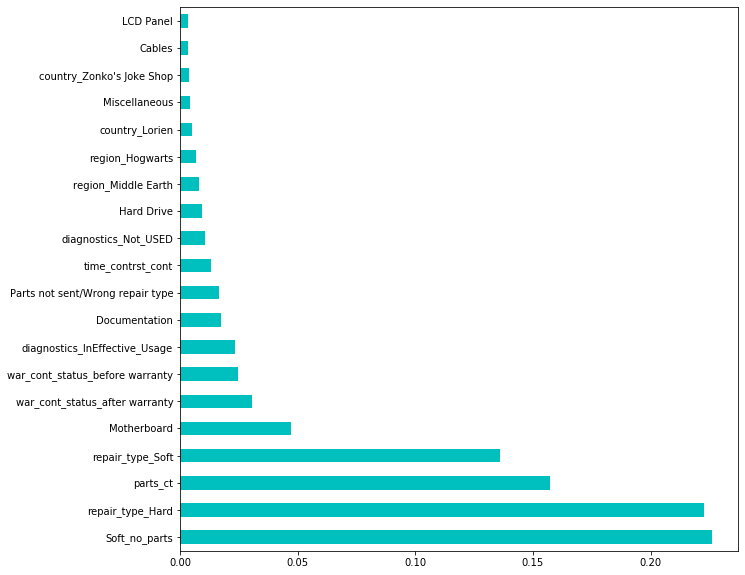

In [487]:
feat_importances = pd.Series(clf1.feature_importances_, index=train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values(ascending=False)[:20].plot(kind='barh',color='c')

# 8.4 Boosting - Light GBM - Change threshold

In [536]:
import lightgbm as lgb
import time
from sklearn.metrics import roc_curve, roc_auc_score, f1_score,auc,accuracy_score
import seaborn as sns

In [537]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(train,label=y_train)
lgb_val=lgb.Dataset(test, label=y_test)

# specify configurations
params = {
    'subsample_for_bin':2000,
    'boosting_type':'goss',
    'objective': 'binary',
    'num_leaves': 31,
    'num_iterations':200,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8,
    'metric' : 'binary_error',
    'scale_pos_weight': 1,
    'reg_alpha': 0.01,
    'max_depth': 2,
    'bagging_fraction': 0.5,
    'bagging_frequency': 5
}

#Tuning parameter
params_grid = {
    'max_depth' : [1,2],
    'learning_rate': [0.07,0.01],
    'n_iterations': [100,200,300],
    'num_leaves': [27,30],
    'boosting_type' : ['gbdt','goss'],
    'colsample_bytree' : [0.5, 0.65],
    'reg_alpha' : [0.01,0.1,0.05],
    'bagging_fraction': [0.4,0.5],
    'bagging_frequency': [5,10]
    }

model = lgb.LGBMClassifier(silent = False,
                           eval_metric=params['metric'],
                           scale_pos_weight=params['scale_pos_weight'])

grid = GridSearchCV(model, params_grid, verbose=1,cv=3)
grid

grid.fit(train, y_train.astype(int))
print("---------------------------------------------------------")
print("The best params are")
print(grid.best_params_)
print(grid.best_score_)

#assigning best params
params['num_leaves']=grid.best_params_['num_leaves']
params['colsample_bytree']=grid.best_params_['colsample_bytree']
params['learning_rate']=grid.best_params_['learning_rate']
params['num_iterations']=grid.best_params_['n_iterations']
params['boosting_type']=grid.best_params_['boosting_type']
params['reg_alpha']=grid.best_params_['reg_alpha']
params['max_depth']=grid.best_params_['max_depth']
params['bagging_frequency']=grid.best_params_['bagging_frequency']
params['bagging_fraction']=grid.best_params_['bagging_fraction']


print("---------------------------------------------------------")
print('Using below parameters to fit: ')
print(params)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3456 out of 3456 | elapsed:  9.1min finished


---------------------------------------------------------
The best params are
{'bagging_fraction': 0.4, 'bagging_frequency': 5, 'boosting_type': 'goss', 'colsample_bytree': 0.65, 'learning_rate': 0.07, 'max_depth': 2, 'n_iterations': 100, 'num_leaves': 27, 'reg_alpha': 0.1}
0.7371208473760231
---------------------------------------------------------
Using below parameters to fit: 
{'subsample_for_bin': 2000, 'boosting_type': 'goss', 'objective': 'binary', 'num_leaves': 27, 'num_iterations': 100, 'learning_rate': 0.07, 'colsample_bytree': 0.65, 'metric': 'binary_error', 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'max_depth': 2, 'bagging_fraction': 0.4, 'bagging_frequency': 5}


In [544]:
#fitting it again
gbm2 = lgb.train(params,lgb_train,num_boost_round=2)

my_threshold=0.5

y_pred = gbm2.predict(train)  # train set
y_predicted=np.where(y_pred > my_threshold, 1, 0)

y_pred_2 = gbm2.predict(test)  # num_iteration=gbm.best_iteration
y_predicted_2=np.where(y_pred_2 > my_threshold, 1, 0)

---------------------------------------------------------
Classification report for train set
AUROC:  0.8142012478647654

              precision    recall  f1-score   support

           0       0.93      0.51      0.66      4154
           1       0.66      0.96      0.79      4154

    accuracy                           0.74      8308
   macro avg       0.80      0.74      0.72      8308
weighted avg       0.80      0.74      0.72      8308

Classification report for test set
AUROC:  0.8004591576240064

              precision    recall  f1-score   support

           0       0.99      0.51      0.67     22953
           1       0.13      0.96      0.23      1780

    accuracy                           0.54     24733
   macro avg       0.56      0.73      0.45     24733
weighted avg       0.93      0.54      0.64     24733

---------------------------------------------------------
The confusion matrix for train set


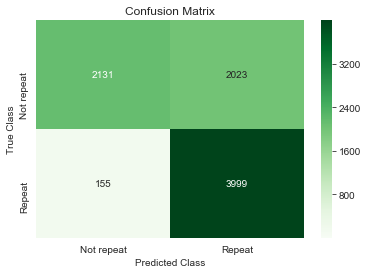

The confusion matrix for val set


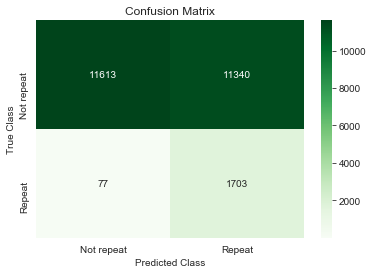

In [545]:
print("---------------------------------------------------------")
#train set
print("Classification report for train set")
false_positive_rate, recall, thresholds = roc_curve(y_train.astype(int), y_pred)
roc_auc = auc(false_positive_rate, recall)
print("AUROC: ", roc_auc)
print()
print(classification_report(y_train.astype(int), y_predicted))

#test set
print("Classification report for test set")
false_positive_rate, recall, thresholds = roc_curve(y_test.astype(int), y_pred_2)
roc_auc = auc(false_positive_rate, recall)
print("AUROC: ", roc_auc)
print()
print(classification_report(y_test.astype(int), y_predicted_2))


print("---------------------------------------------------------")
print("The confusion matrix for train set")
#train set
sns.set_style("whitegrid")
plt.figure()
gbm_cm = confusion_matrix(y_train.astype(int), y_predicted)
labels = ['Not repeat', 'Repeat']
sns.heatmap(gbm_cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Greens", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#validation set
print("The confusion matrix for val set")
sns.set_style("whitegrid")
plt.figure()
gbm_cm = confusion_matrix(y_test.astype(int), y_predicted_2)
labels = ['Not repeat', 'Repeat']
sns.heatmap(gbm_cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Greens", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

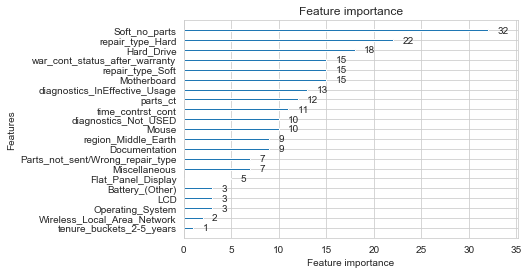

In [497]:
#feature importance
lgb.plot_importance(gbm2, max_num_features=21, importance_type='split')

# 9. Final Observations

<br> From the variable importance plots, the reasons that drive the repeats have been identified and thought on handling it has been jotted down briefly. These are only preliminary recommendations and more specific work can be done with more data.<br> <br> 1. Soft issues have no repeat. So we could aim to help these customers self solve the issue using the support tool <br> 2.Repeats are Likely because fixing a motherboard is a more complex issue. Consider checking quality of the vendor, replacement if it justifies the cost or equip service centers to handle these issues.<br> 3.Consider checking clarity and length of the documentation <br> 4. Training to agents on using diagnostic tool effectively (Focus on Email and Voice) <br>5. Communicate FAQ/ information on support tool to new customers during the time of warranty start<br> <br> This turned to be a longer report than what I had expected. It was an interesting problem and got me working. Thanks for reading!